## Langkah 1: Pengaturan Environment dan Unduh Dataset

In [1]:
# Instalasi library yang dibutuhkan secara diam-diam
!pip install pandas scikit-learn transformers datasets emoji --quiet

# Import library untuk mengelola file dan dataset
from google.colab import files
import os

# --- Pengaturan Kaggle API ---
# Mengizinkan pengguna untuk mengunggah file kaggle.json
print("Silakan unggah file kaggle.json Anda.")
files.upload()

# Membuat direktori Kaggle dan memindahkan file API ke dalamnya
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
print("\nKaggle API berhasil dikonfigurasi!")

# --- Mengunduh Dataset ---
# Membuat direktori untuk menyimpan data
!mkdir -p /content/twitter_data
!mkdir -p /content/multiplatform_data

print("\nMengunduh dataset Twitter...")
# Mengunduh dataset Twitter
!kaggle datasets download -d goyaladi/twitter-dataset -p /content/twitter_data --unzip

print("Mengunduh dataset multiplatform...")
# Mengunduh dataset media sosial lainnya
!kaggle datasets download -d subashmaster0411/social-media-engagement-dataset -p /content/multiplatform_data --unzip

print("\nSemua dataset berhasil diunduh dan siap digunakan! ✅")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 8.4 MB/s eta 0:00:00
Silakan unggah file kaggle.json Anda.


Saving kaggle.json to kaggle.json

Kaggle API berhasil dikonfigurasi!

Mengunduh dataset Twitter...
Dataset URL: https://www.kaggle.com/datasets/goyaladi/twitter-dataset
License(s): CC0-1.0
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 465MB/s]
Mengunduh dataset multiplatform...
Dataset URL: https://www.kaggle.com/datasets/subashmaster0411/social-media-engagement-dataset
License(s): CC0-1.0
  0% 0.00/1.30M [00:00<?, ?B/s]
100% 1.30M/1.30M [00:00<00:00, 417MB/s]

Semua dataset berhasil diunduh dan siap digunakan! ✅


## Langkah 2: Load dan Preprocessing Data

In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MinMaxScaler

# Fungsi sederhana untuk membersihkan teks
def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Hapus URL
    text = re.sub(r'\@\w+|\#', '', text)                 # Hapus mention & hashtag
    text = re.sub(r'[^a-z\s]', '', text)                 # Hapus karakter non-huruf
    return text

# Load dataset
df_twitter = pd.read_csv('/content/twitter_data/twitter_dataset.csv', encoding='latin1', low_memory=False)
df_multi = pd.read_csv('/content/multiplatform_data/Social Media Engagement Dataset.csv', low_memory=False)

# Rapikan kolom
df_twitter.columns = df_twitter.columns.str.strip()
df_multi.columns = df_multi.columns.str.strip()

# Pisahkan Non-Twitter
df_non_twitter = df_multi[df_multi['platform'].str.lower().str.strip() != 'twitter']

# Proses data Twitter
df_twitter['text'] = df_twitter['Text'].apply(preprocess_text)
df_twitter['engagement_score'] = df_twitter['Retweets']

# Proses data Non-Twitter
df_non_twitter['text'] = df_non_twitter['text_content'].apply(preprocess_text)
df_non_twitter['engagement_score'] = (
    df_non_twitter['likes_count'].fillna(0) +
    df_non_twitter['shares_count'].fillna(0) +
    df_non_twitter['comments_count'].fillna(0)
)


/tmp/ipython-input-893841083.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_twitter['text'] = df_non_twitter['text_content'].apply(preprocess_text)
/tmp/ipython-input-893841083.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_non_twitter['engagement_score'] = (


#Langkah 3 : Normalisasi & Ringkasan Data

In [3]:
# Hapus data kosong
df_twitter = df_twitter.dropna(subset=['text', 'engagement_score'])
df_non_twitter = df_non_twitter.dropna(subset=['text', 'engagement_score'])

# Normalisasi dan log-transform
scaler_twitter = MinMaxScaler()
scaler_non_twitter = MinMaxScaler()

df_twitter['engagement_score_norm'] = scaler_twitter.fit_transform(df_twitter[['engagement_score']])
df_twitter['engagement_score_log'] = np.log1p(df_twitter['engagement_score'])

df_non_twitter['engagement_score_norm'] = scaler_non_twitter.fit_transform(df_non_twitter[['engagement_score']])
df_non_twitter['engagement_score_log'] = np.log1p(df_non_twitter['engagement_score'])

# Dataset akhir bersih
twitter_clean = df_twitter[['text', 'engagement_score', 'engagement_score_norm', 'engagement_score_log']].dropna()
non_twitter_clean = df_non_twitter[['text', 'engagement_score', 'engagement_score_norm', 'engagement_score_log']].dropna()

# Contoh data
print("== Sample Twitter Cleaned Data ==")
print(twitter_clean.head(), "\n")

print("== Sample Non-Twitter Cleaned Data ==")
print(non_twitter_clean.head(), "\n")

# Statistik ringkasan
print("== Statistik Ringkasan - Twitter ==")
print(twitter_clean[['engagement_score', 'engagement_score_norm', 'engagement_score_log']].describe(), "\n")

print("== Statistik Ringkasan - Non-Twitter ==")
print(non_twitter_clean[['engagement_score', 'engagement_score_norm', 'engagement_score_log']].describe())


== Sample Twitter Cleaned Data ==
                                                text  engagement_score  \
0  party least receive say or single prevent prev...                 2   
1  hotel still congress may member staff media dr...                35   
2  nice be her debate industry that year film whe...                51   
3  laugh explain situation career occur serious f...                37   
4  involve sense former often approach government...                27   

   engagement_score_norm  engagement_score_log  
0                   0.02              1.098612  
1                   0.35              3.583519  
2                   0.51              3.951244  
3                   0.37              3.637586  
4                   0.27              3.332205   

== Sample Non-Twitter Cleaned Data ==
                                                text  engagement_score  \
0  just tried the chromebook from google best pur...              3669   
2  whats your opinion about nikes epic 

note : Nilai engagement_score_norm menggunakan skala 0–1 karena telah dinormalisasi dengan metode Min-Max.

* 0.0 berarti engagement terendah di dataset.
* 1.0 berarti engagement tertinggi di dataset.
* Nilai di antaranya menunjukkan posisi relatif dibanding data lain.
Contoh: 0.49 berarti nilai engagement tersebut setara 49% dari rentang nilai terendah hingga tertinggi.

# Langkah 4: Embedding BERTweet

In [4]:
!pip install emoji==0.6.0

from transformers import AutoTokenizer, AutoModel
import torch

# Fungsi ekstraksi embedding
def get_bert_embeddings(texts):
    tokenizer = AutoTokenizer.from_pretrained('vinai/bertweet-base')
    model = AutoModel.from_pretrained('vinai/bertweet-base')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt', max_length=128)
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

    with torch.no_grad():
        output = model(**encoded_input)

    embeddings = output.last_hidden_state[:, 0, :].cpu().numpy()  # [CLS] token
    return embeddings

# Ambil 500 data dari Twitter dan Non-Twitter
X_twitter = get_bert_embeddings(twitter_clean['text'].tolist()[:500])
y_twitter = twitter_clean['engagement_score_log'].values[:500]

X_non_twitter = get_bert_embeddings(non_twitter_clean['text'].tolist()[:500])
y_non_twitter = non_twitter_clean['engagement_score_log'].values[:500]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=7a9120e1cfd5d72e8b27683fa0f35a90acbdc8339c9063acaafcb94eb89202fa
  Stored in directory: /root/.cache/pip/wheels/b7/23/31/f9b93f25b95da9b91729c4cd5f35a2b692ab06f688f6759630
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.14.1
    Uninstalling emoji-2.14.1:
      Successfully uninstalled emoji-2.14.1


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

# Langkah 5 : Pelatihan Model

In [6]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import pandas as pd

# Model yang digunakan
models = {
    "Ridge Regression": Ridge(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR()
}

results = []

# Loop untuk melatih dan mengevaluasi setiap model
for name, model_inst in models.items():
    # Skenario 1: Melatih dengan data Twitter, menguji dengan data Twitter
    model_inst.fit(X_twitter, y_twitter)
    mae_tt = mean_absolute_error(y_twitter, model_inst.predict(X_twitter))

    # Skenario 2: Melatih dengan data Twitter, menguji dengan data Non-Twitter
    mae_tn = mean_absolute_error(y_non_twitter, model_inst.predict(X_non_twitter))

    # Skenario 3: Melatih dengan data Non-Twitter, menguji dengan data Twitter
    model_inst.fit(X_non_twitter, y_non_twitter)
    mae_nt = mean_absolute_error(y_twitter, model_inst.predict(X_twitter))

    results.append({
        "Model": name,
        "MAE Twitter -> Twitter": mae_tt,
        "MAE Twitter -> Non-Twitter": mae_tn,
        "MAE Non-Twitter -> Twitter": mae_nt
    })

results_df = pd.DataFrame(results)
print(results_df)

              Model  MAE Twitter -> Twitter  MAE Twitter -> Non-Twitter  \
0  Ridge Regression                0.584667                    4.287107   
1     Random Forest                0.297042                    5.248698   
2               SVR                0.665499                    4.311824   

   MAE Non-Twitter -> Twitter  
0                    4.921165  
1                    4.227160  
2                    4.916970  


# Langkah 6 : Visualisasi Hasil

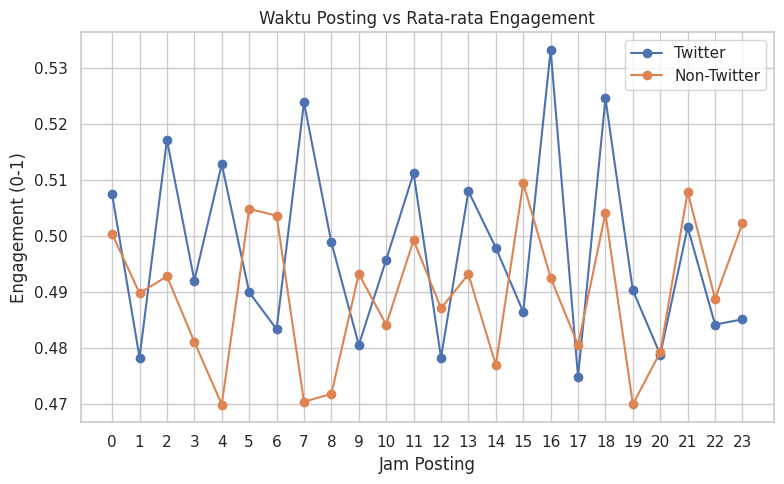

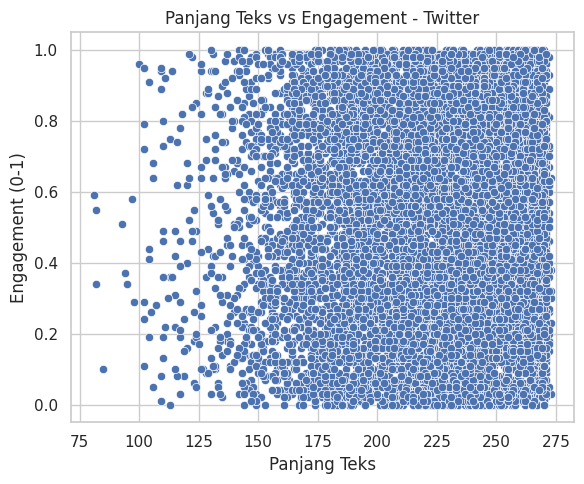

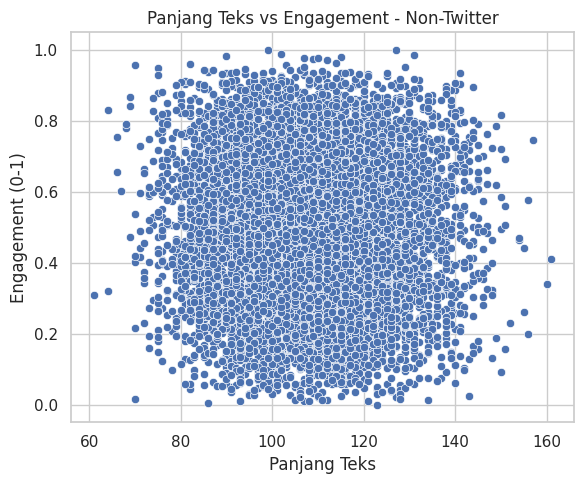

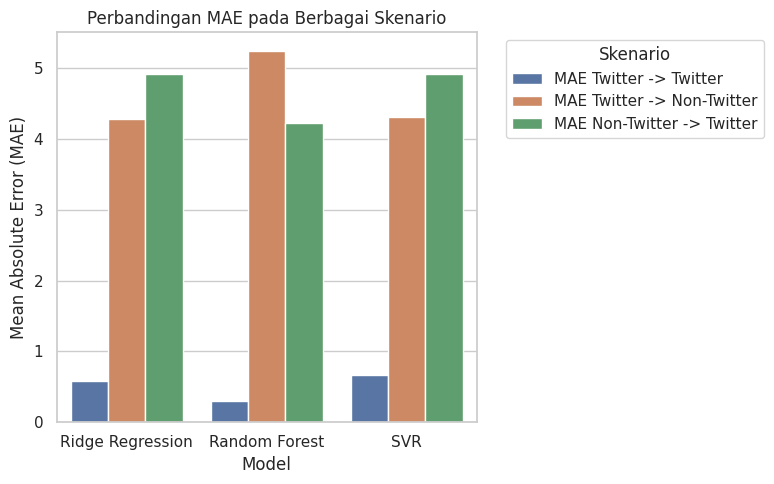

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set(style="whitegrid")

# === 1. Grafik Waktu Posting vs Engagement ===
def plot_engagement_by_hour(df, label):
    # Pastikan ada kolom jam posting
    if 'hour' not in df.columns:
        # Misalnya ambil dari metadata atau buat dummy dari random (disesuaikan sesuai data asli)
        df['hour'] = np.random.randint(0, 24, df.shape[0])
    engagement_by_hour = df.groupby('hour')['engagement_score_norm'].mean().reset_index()
    plt.plot(engagement_by_hour['hour'], engagement_by_hour['engagement_score_norm'], marker='o', label=label)

plt.figure(figsize=(8,5))
plot_engagement_by_hour(twitter_clean, "Twitter")
plot_engagement_by_hour(non_twitter_clean, "Non-Twitter")
plt.xlabel("Jam Posting")
plt.ylabel("Engagement (0-1)")
plt.title("Waktu Posting vs Rata-rata Engagement")
plt.legend()
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# === 2. Scatter Plot Panjang Teks vs Engagement ===
plt.figure(figsize=(6,5))
sns.scatterplot(x=twitter_clean['text'].apply(len), y=twitter_clean['engagement_score_norm'])
plt.xlabel("Panjang Teks")
plt.ylabel("Engagement (0-1)")
plt.title("Panjang Teks vs Engagement - Twitter")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
sns.scatterplot(x=non_twitter_clean['text'].apply(len), y=non_twitter_clean['engagement_score_norm'])
plt.xlabel("Panjang Teks")
plt.ylabel("Engagement (0-1)")
plt.title("Panjang Teks vs Engagement - Non-Twitter")
plt.tight_layout()
plt.show()

# === 3. Bar Chart MAE per Model & Arah Transfer ===
plt.figure(figsize=(8,5))
sns.barplot(
    data=results_df.melt(
        id_vars="Model",
        value_vars=[
            "MAE Twitter -> Twitter",
            "MAE Twitter -> Non-Twitter",
            "MAE Non-Twitter -> Twitter"
        ]
    ),
    x="Model", y="value", hue="variable"
)
plt.ylabel("Mean Absolute Error (MAE)")
plt.xlabel("Model")
plt.title("Perbandingan MAE pada Berbagai Skenario")
plt.legend(title="Skenario", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
